Elo rating trend

C:\Users\dongm\AppData\Local\Temp\ipykernel_18500\3381463338.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lakers_games_2223.loc[:, 'lakers_elo_rank'] = lakers_games_2223.apply(find_lakers_ranking, axis=1)


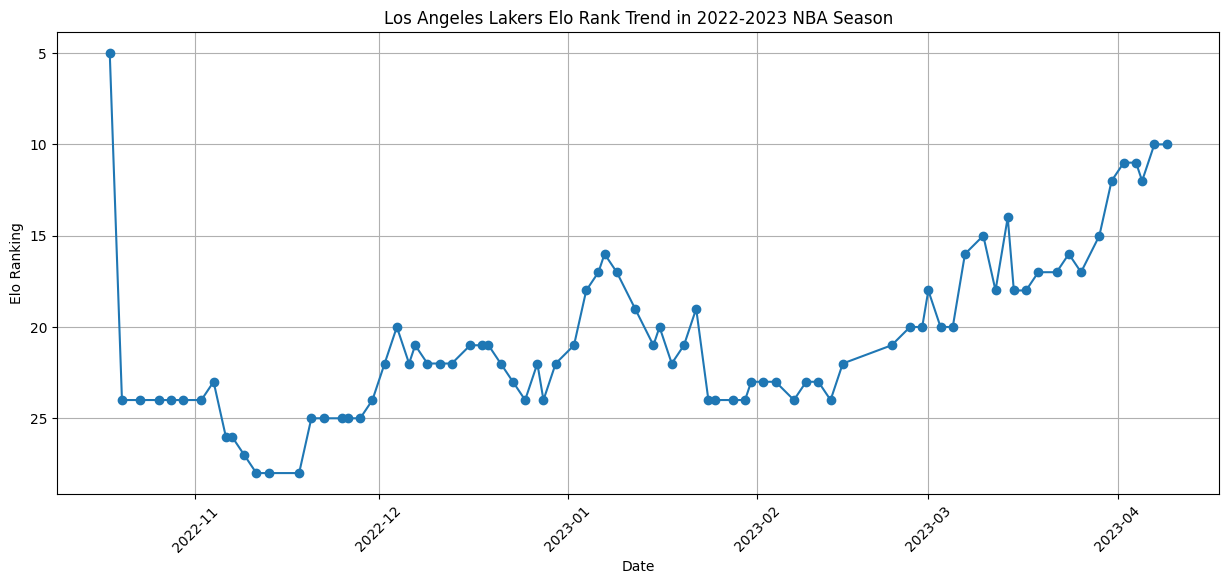

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the NBA Elo data
file_path = 'nba_elo.csv'  # Replace with your file path
nba_elo = pd.read_csv(file_path)

# Filter for the 2022-2023 season for all teams
nba_elo['date'] = pd.to_datetime(nba_elo['date'])
nba_elo_2223_season_all = nba_elo[(nba_elo['season'] == 2023) & (nba_elo['date'] >= '2022-10-18') & (nba_elo['date'] < '2023-4-10')]

# Create a DataFrame to store the Elo ratings after each game
elo_ratings = pd.DataFrame()

# Process each game to update the latest Elo ratings of the teams involved
for index, row in nba_elo_2223_season_all.iterrows():
    date = row['date']
    team1 = row['team1']
    team2 = row['team2']
    elo1_post = row['elo1_post']
    elo2_post = row['elo2_post']

    # Update the Elo rating for team1 and team2
    elo_ratings.at[date, team1] = elo1_post
    elo_ratings.at[date, team2] = elo2_post

# Forward fill the Elo ratings (for days when a team didn't play)
elo_ratings_filled = elo_ratings.sort_index().fillna(method='ffill')

# Reset index to keep the date as a column
elo_ratings_filled.reset_index(inplace=True)
elo_ratings_filled.rename(columns={'index': 'date'}, inplace=True)

# Filter for Lakers' games
lakers_games_2223 = nba_elo_2223_season_all[(nba_elo_2223_season_all.team1 == 'LAL') | (nba_elo_2223_season_all.team2 == 'LAL')]

# Function to find Lakers' ranking on a given date
def find_lakers_ranking(row):
    date = row['date']
    lakers_elo = elo_ratings_filled[elo_ratings_filled['date'] == date]['LAL'].values[0]
    ratings_on_date = elo_ratings_filled[elo_ratings_filled['date'] == date].drop(columns=['date']).iloc[0]
    rank = np.sum(ratings_on_date >= lakers_elo)  # Count how many teams have a higher or equal rating
    return rank + 1  # Rank among the teams

# Apply the function to get the Lakers' ranking after each game
lakers_games_2223.loc[:, 'lakers_elo_rank'] = lakers_games_2223.apply(find_lakers_ranking, axis=1)

plt.figure(figsize=(15, 6))
plt.plot(lakers_games_2223['date'].values, lakers_games_2223['lakers_elo_rank'].values, marker='o')  # Convert to numpy array
plt.gca().invert_yaxis()  # Invert y-axis so that a lower rank is at the top
plt.title('Los Angeles Lakers Elo Rank Trend in 2022-2023 NBA Season')
plt.xlabel('Date')
plt.ylabel('Elo Ranking')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Actual standing

C:\Users\dongm\AppData\Local\Temp\ipykernel_18500\4048903990.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nba_elo_2223['win'] = nba_elo_2223['score1'] > nba_elo_2223['score2']
C:\Users\dongm\AppData\Local\Temp\ipykernel_18500\4048903990.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nba_elo_2223['loss'] = ~nba_elo_2223['win']


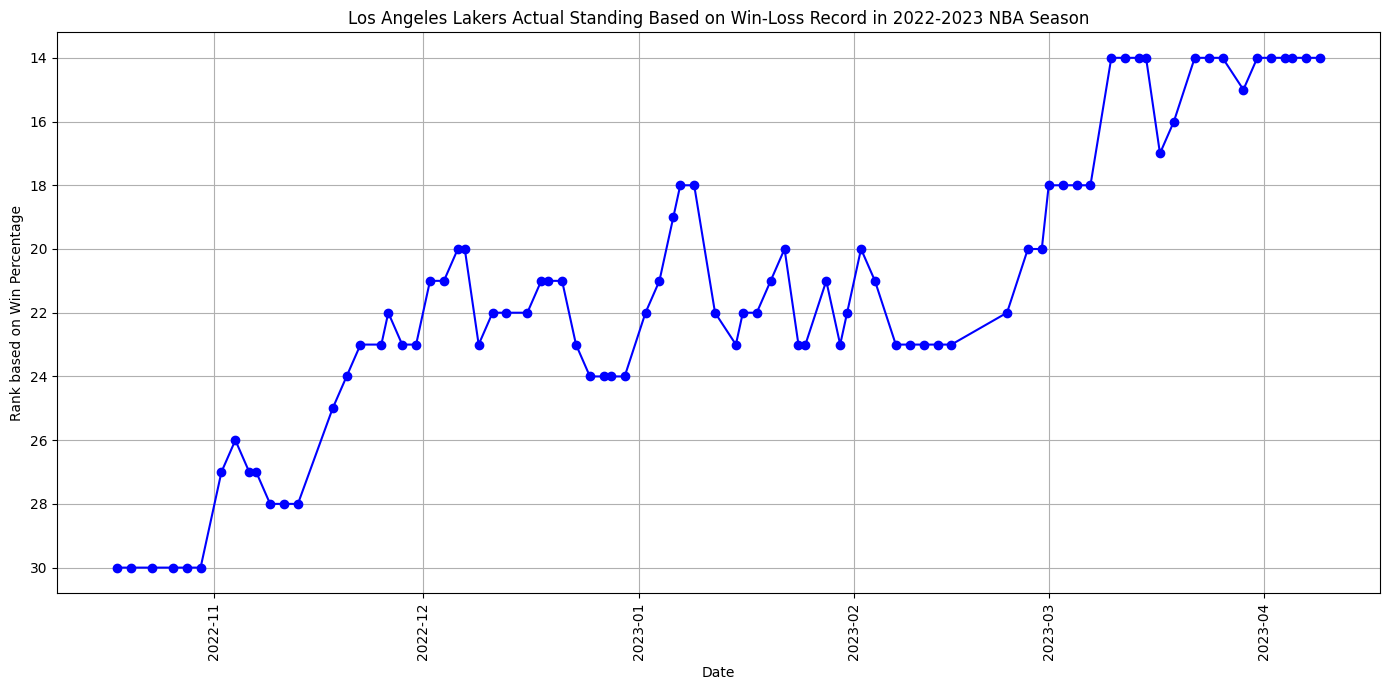

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the NBA Elo data from the provided CSV file
nba_elo = pd.read_csv('nba_elo.csv')

# Filter the DataFrame for the 2022-2023 regular season
nba_elo['date'] = pd.to_datetime(nba_elo['date'])
nba_elo_2223 = nba_elo[(nba_elo['season'] == 2023) & (nba_elo['date'] >= '2022-10-18') & (nba_elo['date'] < '2023-4-10')]

# Determine wins and losses
nba_elo_2223['win'] = nba_elo_2223['score1'] > nba_elo_2223['score2']
nba_elo_2223['loss'] = ~nba_elo_2223['win']

# Create a wins and losses DataFrame for all teams
teams = nba_elo_2223['team1'].unique()
wins_losses = pd.DataFrame(index=nba_elo_2223['date'].unique(), columns=teams)

# Populate the wins and losses DataFrame
for date, row in nba_elo_2223.iterrows():
    wins_losses.at[row['date'], row['team1']] = row['win']
    wins_losses.at[row['date'], row['team2']] = not row['win']

# Forward fill the wins and losses to carry them forward through the dates
wins_losses = wins_losses.sort_index().fillna(method='ffill').fillna(False).cumsum()

# Calculate the win percentage for the Lakers
lakers_wins = wins_losses['LAL']
lakers_losses = nba_elo_2223.groupby('date')['loss'].sum() - lakers_wins
lakers_win_pct = lakers_wins / (lakers_wins + lakers_losses)

# Calculate the Lakers' rank by comparing win percentage with all teams
lakers_actual_rank = wins_losses.apply(lambda x: (x >= lakers_wins[x.name]).sum(), axis=1)

# Filter for the Lakers' games to plot their rank over the season
lakers_games = nba_elo_2223[(nba_elo_2223['team1'] == 'LAL') | (nba_elo_2223['team2'] == 'LAL')]
lakers_games = lakers_games.sort_values('date')
lakers_ranks_on_game_days = lakers_actual_rank.loc[lakers_games['date']].sort_index()

plt.figure(figsize=(14, 7))
plt.plot(lakers_ranks_on_game_days.index.values, lakers_ranks_on_game_days.values, marker='o', linestyle='-', color='blue')
plt.gca().invert_yaxis()  # Higher rank should be at the top
plt.title('Los Angeles Lakers Actual Standing Based on Win-Loss Record in 2022-2023 NBA Season')
plt.xlabel('Date')
plt.ylabel('Rank based on Win Percentage')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()
